# Final LDA Model

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from datetime import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# TF.IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging', 'hof', 'althans', 'tenlastegelegd', 'naan', 'verklaring', 'verklaren', 'benadelen', 'naam', 'aangeefster', 'aangever', 'aangev', 'verbalisant', 'slachtoffer', 'rechtbank', 'uur', 'uren', 'weten', 'bestaan', 'waarheid', 'daarvoor', 'genaamd', 'maken', 'gaan', 'toverweging', 'aanzien', 'bewijs', 'feit', 'grond', 'staan', 'vaststellen', 'halen', 'vervolgens', 'nemen', 'aanhouden', 'bevinden', 'officier', 'justitie', 'overtuigen', 'bewijzen', 'maken', 'stellen', 'leggen', 'dienen', 'vrijspreken', 'daarnaast', 'bezigen', 'willen', 'gaan', 'vervolgens', 'raken', 'weten', 'proberen', 'echter', 'vraag', 'verdenken', 'vervatten', 'beslissing', 'hoger_beroep', 'verkort_vonni', 'geacht', 'instellen', 'ander', 'zien', 'toebehoren', 'hoeveelheid', 'lijst_ii', 'bereiken'])

# Data 1

In [3]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=6, parse_dates=['date']) 

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)


In [4]:
df.head()

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete
date,,,,,,,
2018-01-08,3,ECLI_NL_RBGEL_2018_50.xml,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,[][' tenlastelegging aan verdachte is ten la...
2019-01-25,4,ECLI_NL_GHAMS_2019_194.xml,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,[' het bewijs tegen de verdachte de kern...
2021-02-10,7,ECLI_NL_RBOVE_2021_606.xml,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),"[][' tenlastelegging de verdenking komt er, ..."
2021-02-10,8,ECLI_NL_GHSHE_2021_1801.xml,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,[' bewijsmiddelen indien tegen dit ve...
2020-01-30,9,ECLI_NL_GHARL_2020_820.xml,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,"[' bewijsmiddelen, feiten en omstandighed..."


# Data 2

In [5]:

''''
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_18_21.csv', index_col=5, parse_dates=['date']) 
df = df.drop(labels=['ecli', 'case_nr', 'bewijs'], axis=1)
df = df.rename(columns={"tll": "bete"})
df.head()
'''

'\'\ndf = pd.read_csv(\'/Users/dj/Python - UvA/DSP/data/dataset_18_21.csv\', index_col=5, parse_dates=[\'date\']) \ndf = df.drop(labels=[\'ecli\', \'case_nr\', \'bewijs\'], axis=1)\ndf = df.rename(columns={"tll": "bete"})\ndf.head()\n'

In [6]:
df18 = df.loc["2018-01-01 00:00:00":"2018-12-31 00:00:00"]
df19 = df.loc["2019-01-01 00:00:00":"2019-12-31 00:00:00"]
df20 = df.loc["2020-01-01 00:00:00":"2020-12-31 00:00:00"]
df21 = df.loc["2021-01-01 00:00:00":"2021-12-31 00:00:00"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated 

In [7]:
print(df18.shape)
print(df19.shape)
print(df20.shape)
print(df21.shape)

(300, 7)
(306, 7)
(315, 7)
(527, 7)


# Build Giant Function

In [8]:

def get_lda_model(df):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(df['bete']))

        # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    nlp = spacy.load("nl_core_news_sm")

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out



    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    # nlp = spacy.load('nl', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    data_lemmatized = remove_stopwords(data_lemmatized)

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # corpus1 = [str(item) for item in corpus]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


    ######## TF.IDF ########

    dat_lem_untok = [" ".join(x) for x in data_lemmatized]
    tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)
    tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
    tfidf_df = tfidf_df.stack().reset_index()
    tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
    top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

     

    return(lda_model, data_lemmatized, corpus, id2word, top_tfidf)

In [9]:
d = [df18, df19, df20, df21]
q = 1
lda_models = []
dat_lems = []
corps = []
ids = []
top_idfs = []

for i in d:
    print(q)
    q += 1
    l, dl, c, i2words, t = get_lda_model(i)
    lda_models.append(l)
    dat_lems.append(dl)
    corps.append(c)
    ids.append(i2words)
    top_idfs.append(t)



1
2
3
4


# Compute Model Perplexity and Coherence Score

In [10]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 3

# Compute Perplexity
print('\nPerplexity: ', lda_models[a].log_perplexity(corps[a]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_models[a], texts=dat_lems[a], dictionary=ids[a], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.504170862140938

Coherence Score:  0.4612774046994995


# Visualize the topics-keywords

In [11]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 0

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[a], corps[a], ids[a], R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.167732 -0.104992       1        1  28.517124
4     -0.057874  0.060748       2        1  23.901768
1      0.120433  0.128441       3        1  20.214275
3     -0.140857  0.036410       4        1  15.930232
2     -0.089434 -0.120608       5        1  11.436602, topic_info=            Term        Freq        Total Category  logprob  loglift
2306   betrokken  787.000000   787.000000  Default  10.0000  10.0000
986         bank  321.000000   321.000000  Default   9.0000   9.0000
183          man  755.000000   755.000000  Default   8.0000   8.0000
591        slaan  722.000000   722.000000  Default   7.0000   7.0000
185    mededader  399.000000   399.000000  Default   6.0000   6.0000
...          ...         ...          ...      ...      ...      ...
261   vereniging  130.835381   620.692878   Topic5  -4.8137   0.6115
210      persoon  128.890135   692.329269   Topic5  -4.8286   0.4872
313        adres  140.978806  1020.206159   Topic5  -4.7390   0.1892
212       plaats  116.129854   759.706784   Topic5  -4.9329   0.2901
52       periode  113.838041   628.546498   Topic5  -4.9528   0.4597

[140 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
88        1  0.192388  aantreffen
88        2  0.456922  aantreffen
88        3  0.067773  aantreffen
88        4  0.048097  aantreffen
88        5  0.233926  aantreffen
...     ...       ...         ...
86        2  0.090956      zeggen
86        3  0.548580      zeggen
86        4  0.051163      zeggen
86        5  0.009948      zeggen
5493      5  0.962662    zoekterm

[310 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

# TF.IDF 

In [12]:
test = top_idfs[0].sort_values(by=['tfidf'], ascending=[False]).head(20)

In [13]:
top_idfs[0].sort_values(by=['tfidf'], ascending=[False]).head(20)

,document,term,tfidf
846311,102,inleiding,1.000000
69614,8,kledingwinkel,0.864611
168806,20,kledingwinkel,0.850613
1549824,187,meerkerk,0.849084
868844,105,betrokken,0.836630
44088,5,handelsnaam,0.747824
2029373,245,minderjarig,0.734323
405657,49,bedrijf,0.730678
1559082,188,pagina,0.721468
1932826,233,tussenkomst,0.716773


In [14]:
top_idfs[3][top_idfs[3]['term'].str.contains('hof')]

,document,term,tfidf


In [15]:
values = []
years = ('2018', '2019', '2020', '2021')
term = 'kledingwinkel'

def avg_terms(data, term):
    avg = data[data['term'].str.contains(term)]['tfidf'].mean()
    return(avg)
    
for i in top_idfs:
    if term in list(i['term']):
        a  = avg_terms(i, term)
        values.append(a)
    else:
        values.append(0)

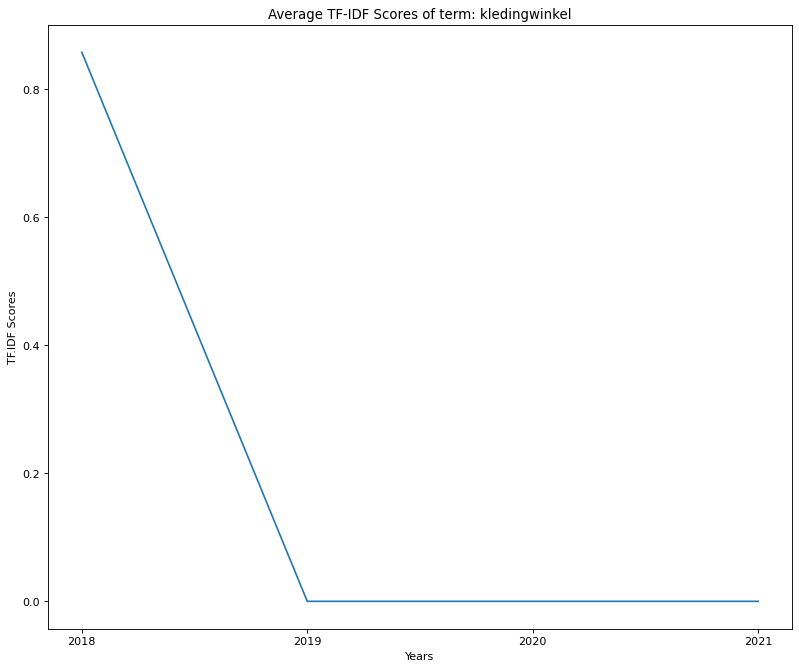

In [16]:
x_pos = [0,1,2,3]

figure(figsize=(12, 10), dpi=80)

plt.plot(values)


# Add title and axis names
plt.title('Average TF-IDF Scores of term: {}'.format(term))
plt.xlabel('Years')
plt.ylabel('TF.IDF Scores')
 
# Create names on the x axis
plt.xticks(x_pos, years)
 
# Show graph
plt.show()

In [17]:
values

[0.8576124034348787, 0, 0, 0]

In [18]:
import altair as alt
import numpy as np

# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 0

# Terms in this list will get a red dot in the visualization
term_list = ['kledingwinkel', 'albert_heijn'] # Highlight the words of interest

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_idfs[a].copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:500,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 1200)

alt.LayerChart(...)

# Scattertext

For some reason, this plot does not work in visual studio code. One has to use the jupyter notebook in the safari browser. At least thats the case for me. 

In [19]:
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
display(HTML("<style>.container { width:98% !important; }</style>"))

In [20]:
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
import selenium
from selenium import webdriver
import webbrowser
import codecs
display(HTML("<style>.container { width:98% !important; }</style>"))

In [21]:
d0 = d[0]
d1 = d[1]

d[0]['lemm'] = [" ".join(x) for x in dat_lems[0]]
d[1]['lemm'] = [" ".join(x) for x in dat_lems[1]]

d0['year'] = pd.to_datetime(d0.index).year
d1['year'] = pd.to_datetime(d1.index).year

d0['year'] = d0['year'].astype("string")
d1['year'] = d1['year'].astype("string")

frames = [d0, d1]

result = pd.concat(frames)

nlp = spacy.load("nl_core_news_sm")

In [22]:
result['parsed'] = result.lemm.apply(nlp)

In [23]:
result = result.rename(columns={"Unnamed: 0": "Doc_Number"})
result["Doc_Number"] = result["Doc_Number"].astype("category")
result["year"] = result["year"].astype("category")

In [24]:
corpus_scat_text = st.CorpusFromParsedDocuments(result, category_col='year', parsed_col='parsed').build()

In [25]:
html = produce_scattertext_explorer(corpus_scat_text,
                                    category='2018',
                                    category_name='2018',
                                    not_category_name='2019',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    metadata=corpus_scat_text.get_df()['filename'],
                                    transform= st.Scalers.log_scale_standardize) 


In [26]:
import codecs
import webbrowser
import IPython

file_name = 'result_scatter_scale.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

In [27]:
# Trying so use data_lemmatized as input
test = df.iloc[0:10, :]

In [28]:
test['test'] = test.bete.apply(nlp)

In [29]:
test.head()

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete,test
date,,,,,,,,
2018-01-08,3,ECLI_NL_RBGEL_2018_50.xml,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,[][' tenlastelegging aan verdachte is ten la...,"([, ], [, ', tenlastelegging, , aan, verdach..."
2019-01-25,4,ECLI_NL_GHAMS_2019_194.xml,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,[' het bewijs tegen de verdachte de kern...,"([, ', , het, bewijs, tegen, de, verdacht..."
2021-02-10,7,ECLI_NL_RBOVE_2021_606.xml,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),"[][' tenlastelegging de verdenking komt er, ...","([, ], [, ', tenlastelegging, , de, verdenki..."
2021-02-10,8,ECLI_NL_GHSHE_2021_1801.xml,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,[' bewijsmiddelen indien tegen dit ve...,"([, ', , bewijsmiddelen, , indien, te..."
2020-01-30,9,ECLI_NL_GHARL_2020_820.xml,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,"[' bewijsmiddelen, feiten en omstandighed...","([, ', , bewijsmiddelen, ,, feiten, en, o..."


In [30]:
type(test['bete'][0])

str

In [31]:
type(test['test'][0])

spacy.tokens.doc.Doc

In [32]:
d[0].shape

(300, 9)

In [33]:
len(dat_lems[3])

527

In [34]:
d[0]['lemm'] = dat_lems[0]

In [35]:
d[0].head()

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete,lemm,year
date,,,,,,,,,
2018-01-08,3,ECLI_NL_RBGEL_2018_50.xml,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,[][' tenlastelegging aan verdachte is ten la...,"[laste_gelegd, periode, oostenrijk, opzettelij...",2018
2018-01-24,24,ECLI_NL_GHAMS_2018_185.xml,ECLI:NL:GHAMS:2018:185,Strafrecht,Amsterdam,23-002003-17,[' bewijsverweren ter terechtzitting ...,"[bewijsverweren, terechtzitting, raadsman, sta...",2018
2018-01-26,31,ECLI_NL_RBMNE_2018_269.xml,ECLI:NL:RBMNE:2018:269,Strafrecht,Utrecht,16/705582-17 (P),[' bewijsmiddelen ten aanzien van de...,"[bewijsmiddel, volgen, bewonen, vrouw, zoon, v...",2018
2018-01-26,62,ECLI_NL_GHARL_2018_849.xml,ECLI:NL:GHARL:2018:849,Strafrecht,NaN,21-005366-16,[][' tenlastelegging aan verdachte is tenlas...,"[primair, plaats, gemeente, gemeente, uitvoeri...",2018
2018-01-03,74,ECLI_NL_GHARL_2018_108.xml,ECLI:NL:GHARL:2018:108,Strafrecht,Arnhem,21-002023-17,[][' tenlastelegging aan verdachte is – voor...,"[zover, oordeel, onderwerpen, laste_gelegd, za...",2018


In [36]:
dat_lem_untok = [" ".join(x) for x in dat_lems[0]]

In [37]:
len(dat_lem_untok)

300

In [53]:
type(d[0]['lemm'][0][0])

str

In [54]:
'''
d 
q 
lda_models 
dat_lems 
corps 
ids 
top_idfs 
'''

'\nd \nq \nlda_models \ndat_lems \ncorps \nids \ntop_idfs \n'

In [57]:
d[0]

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete,lemm,year
date,,,,,,,,,
2018-01-08,3,ECLI_NL_RBGEL_2018_50.xml,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,[][' tenlastelegging aan verdachte is ten la...,"[laste_gelegd, periode, oostenrijk, opzettelij...",2018
2018-01-24,24,ECLI_NL_GHAMS_2018_185.xml,ECLI:NL:GHAMS:2018:185,Strafrecht,Amsterdam,23-002003-17,[' bewijsverweren ter terechtzitting ...,"[bewijsverweren, terechtzitting, raadsman, sta...",2018
2018-01-26,31,ECLI_NL_RBMNE_2018_269.xml,ECLI:NL:RBMNE:2018:269,Strafrecht,Utrecht,16/705582-17 (P),[' bewijsmiddelen ten aanzien van de...,"[bewijsmiddel, volgen, bewonen, vrouw, zoon, v...",2018
2018-01-26,62,ECLI_NL_GHARL_2018_849.xml,ECLI:NL:GHARL:2018:849,Strafrecht,NaN,21-005366-16,[][' tenlastelegging aan verdachte is tenlas...,"[primair, plaats, gemeente, gemeente, uitvoeri...",2018
2018-01-03,74,ECLI_NL_GHARL_2018_108.xml,ECLI:NL:GHARL:2018:108,Strafrecht,Arnhem,21-002023-17,[][' tenlastelegging aan verdachte is – voor...,"[zover, oordeel, onderwerpen, laste_gelegd, za...",2018
...,...,...,...,...,...,...,...,...,...
2018-01-19,2875,ECLI_NL_RBROT_2018_1631.xml,ECLI:NL:RBROT:2018:1631,Strafrecht,Rotterdam,10/691154-17,[' bewijswaardering 4.1.1. standpunt verd...,"[standpunt, verdediging, bekend, groot, hennep...",2018
2018-01-26,2876,ECLI_NL_RBMNE_2018_270.xml,ECLI:NL:RBMNE:2018:270,Strafrecht,Utrecht,16/707109-16 (P),[' bewijsmiddelen ten aanzien van de...,"[bewijsmiddel, volgen, bewonen, samen, vrouw, ...",2018
2018-01-05,2878,ECLI_NL_RBROT_2018_1625.xml,ECLI:NL:RBROT:2018:1625,Strafrecht,Rotterdam,10/652103-16,[][' tenlastelegging aan de verdachte word...,"[laste_gelegd, tezamen, vereniging, alleen, oo...",2018


In [58]:
top_idfs[0]

,document,term,tfidf
3458,0,kind,0.450057
4203,0,minderjarig,0.277413
6477,0,tandarts,0.275668
2368,0,geboorteplaats,0.261528
6813,0,trein,0.241599
...,...,...,...
2478260,299,toestemming,0.187795
2479746,299,zoon,0.184555
2478899,299,vertrekken,0.147202
2476247,299,onttrekking,0.133293


In [42]:
test = pd.read_csv('/Users/dj/Python - UvA/DSP/data_2018.csv', index_col=0) 

In [46]:
type(test.index[0])

str